# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [DELANNOY Rosalie]([link](https://github.com/rosedel05))
- [DOS RAMOS Carl]([link](https://github.com/carldosramos8-prog))

```
conda create --name=lab3 --file=requirement.txt
conda activate lab3
# do not forget to deactivate the environment if needed
# you can remove the environment once you are done
conda env remove --name=lab3
```

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

**Answer:**

Nous initialisons un générateur pseudo-aléatoire NumPy avec une graine fixe afin d'obtenir des trajectoires reproductibles.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

> Recall of the Linear Interpolation (LERP) for $n$-dimensional vectors:
> - Clearly, $\vec{D}=\alpha \vec{C}$ with $\alpha \in [0, 1]$ and hence $\vec{P}-\vec{B}= \alpha (\vec{A}-\vec{B})$ which is equivalent to $\vec{P}= (1-\alpha) \vec{B} + \alpha \vec{A}$. 
![alternatvie text](img/for_Course.png)

**Answer:**

La fonction simule l'errance aléatoire itération par itération et, lorsque le dernier segment quitte le disque unité, elle résout l'équation quadratique issue de $\lVert W(t) \rVert^2 = 1$ pour interpoler le point d'impact exact sur le bord.

In [3]:
def brownian_motion(niter, x, step, rng):
    """Simule un mouvement brownien 2D dans le disque unité.

    Parameters
    ----------
    niter : int
        Nombre maximal d'itérations à simuler.
    x : array-like de taille 2
        Position initiale à l'intérieur du disque unité.
    step : float
        Pas temporel (delta).
    rng : np.random.Generator
        Générateur pseudo-aléatoire.

    Returns
    -------
    traj : np.ndarray
        Trajectoire simulée (points successifs).
    boundary : np.ndarray or None
        Point d'intersection avec le bord si atteint, sinon None.
    """
    current = np.asarray(x, dtype=float)
    if current.shape != (2,):
        raise ValueError("x doit être un vecteur de taille 2")
    if np.linalg.norm(current) > 1.0:
        raise ValueError("Le point initial doit être dans le disque unité")

    traj = [current.copy()]
    boundary = None

    for _ in range(int(niter)):
        step_vector = rng.normal(size=2)
        proposal = current + np.sqrt(step) * step_vector
        traj.append(proposal.copy())

        if np.linalg.norm(proposal) >= 1.0:
            direction = proposal - current
            a = np.dot(direction, direction)
            b = 2.0 * np.dot(current, direction)
            c = np.dot(current, current) - 1.0

            if a == 0:
                boundary = proposal.copy()
            else:
                roots = np.roots([a, b, c])
                real_roots = roots[np.isreal(roots)].real
                mask = (real_roots >= 0) & (real_roots <= 1)
                if not np.any(mask):
                    boundary = proposal.copy()
                else:
                    t_hit = real_roots[mask].min()
                    boundary = current + t_hit * direction

            traj[-1] = boundary.copy() if boundary is not None else proposal.copy()
            break

        current = proposal

    return np.array(traj), boundary


3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

La trajectoire part de $(0{,}2, 0{,}4)$, évolue par petits pas gaussiens et finit par toucher le cercle unité ; nous mettons en évidence le point de sortie sur la figure.

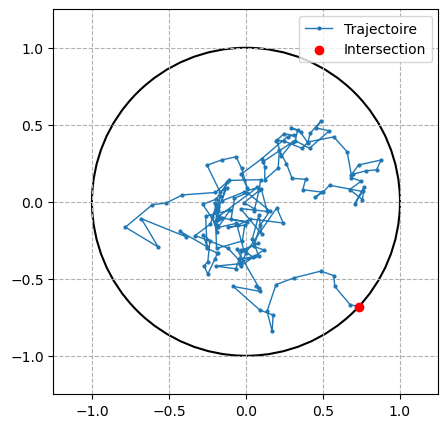

In [4]:
start = np.array([0.2, 0.4])
step = 1e-2
niter = 1000
traj, boundary = brownian_motion(niter, start, step, rng)

fig, ax = plt.subplots(figsize=(5, 5))
circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='none', linewidth=1.5)
ax.add_artist(circle)
ax.plot(traj[:, 0], traj[:, 1], marker='o', markersize=2, linewidth=1, label='Trajectoire')

if boundary is not None:
    ax.scatter(boundary[0], boundary[1], color='red', zorder=5, label='Intersection')

ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.25, 1.25)
ax.set_aspect('equal', adjustable='box')
ax.grid(linestyle='--', zorder=0)
ax.legend(loc='upper right')
plt.show()


4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

Les trajectoires supplémentaires montrent la variabilité liée aux tirages aléatoires : toutes restent confinées jusqu'au premier contact avec le bord, mais suivent des chemins distincts avant d'atteindre le cercle unité.

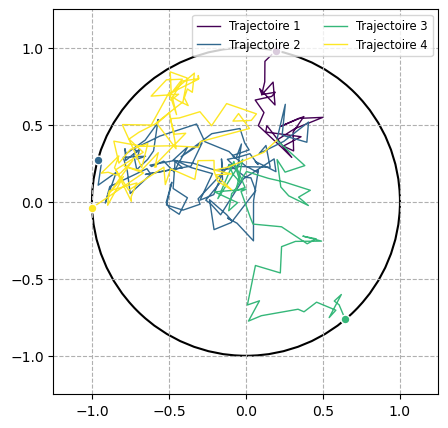

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
circle = plt.Circle((0, 0), 1, edgecolor='black', facecolor='none', linewidth=1.5)
ax.add_artist(circle)

colors = plt.cm.viridis(np.linspace(0, 1, 4))
for idx, color in enumerate(colors, start=1):
    traj_extra, boundary_extra = brownian_motion(niter, start, step, rng)
    ax.plot(traj_extra[:, 0], traj_extra[:, 1], color=color, linewidth=1, label=f'Trajectoire {idx}')
    if boundary_extra is not None:
        ax.scatter(boundary_extra[0], boundary_extra[1], color=color, edgecolor='white', s=40, zorder=5)

ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.25, 1.25)
ax.set_aspect('equal', adjustable='box')
ax.grid(linestyle='--', zorder=0)
ax.legend(loc='upper right', ncol=2, fontsize='small')
plt.show()


5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

**Answer:**

On procède de la même façon en dimension $M$: les incréments restent gaussiens i.i.d. et l'intersection avec la sphère unité s'obtient en résolvant $\lVert W_{n-1} + t (W_n - W_{n-1}) \rVert^2 = 1$, ce qui conduit encore à une équation quadratique en $t$ quelle que soit la dimension.

In [6]:
def brownian_motion_nd(niter, x, step, rng):
    """Généralisation du mouvement brownien au cas M-dimensionnel.

    Retourne la trajectoire simulée et, si atteint, le point sur la sphère unité.
    """
    x = np.asarray(x, dtype=float)
    if np.linalg.norm(x) > 1.0:
        raise ValueError("Le point initial doit appartenir à la boule unité")

    traj = [x.copy()]
    current = x.copy()
    boundary = None

    for _ in range(int(niter)):
        proposal = current + np.sqrt(step) * rng.normal(size=x.shape)
        traj.append(proposal.copy())

        norm_proposal = np.linalg.norm(proposal)
        if norm_proposal >= 1.0:
            direction = proposal - current
            a = np.dot(direction, direction)
            b = 2.0 * np.dot(current, direction)
            c = np.dot(current, current) - 1.0

            if a == 0:
                boundary = proposal.copy()
            else:
                roots = np.roots([a, b, c])
                real_roots = roots[np.isreal(roots)].real
                mask = (real_roots >= 0) & (real_roots <= 1)
                if np.any(mask):
                    t_hit = real_roots[mask].min()
                    boundary = current + t_hit * direction
                else:
                    boundary = proposal.copy()

            traj[-1] = boundary.copy() if boundary is not None else proposal.copy()
            break

        current = proposal

    return np.array(traj), boundary

# Exemple rapide en dimension 3 (non affiché)
_ = brownian_motion_nd(100, np.zeros(3), step, rng)


---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

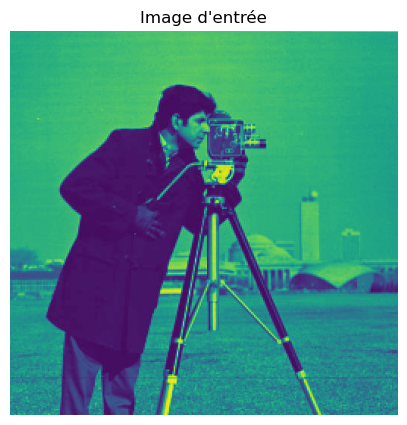

In [11]:
from pathlib import Path

image_path = Path('img/cameraman.png')
X = plt.imread(image_path).astype(float)
if X.ndim == 3:
    # Conversion éventuelle vers un niveau de gris unique
    X = X[..., 0] if X.shape[2] == 1 else X.mean(axis=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(X)
ax.set_title("Image d'entrée")
ax.axis('off')
plt.show()


2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

(a) Sans recentrage, la fréquence nulle apparaît dans le coin supérieur gauche (indice $(0,0)$).
(b) L'utilisation de `np.fft.fftshift` ramène les basses fréquences au centre du spectre, rendant la lecture plus intuitive.

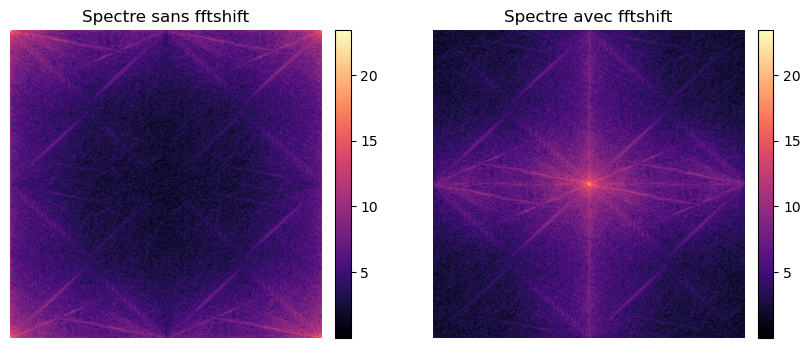

In [8]:
FX = np.fft.fft2(X)
spectrum = np.abs(FX) ** 2

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im0 = axes[0].imshow(np.log1p(spectrum), cmap='magma')
axes[0].set_title('Spectre sans fftshift')
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

shifted_spectrum = np.fft.fftshift(spectrum)
im1 = axes[1].imshow(np.log1p(shifted_spectrum), cmap='magma')
axes[1].set_title('Spectre avec fftshift')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
plt.show()


3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

**Answer:**

Plus les coupures $f_{c,y}$ et $f_{c,x}$ augmentent, plus on conserve de hautes fréquences : l'image filtrée gagne en détails mais laisse aussi réapparaître le bruit et les contours marqués.

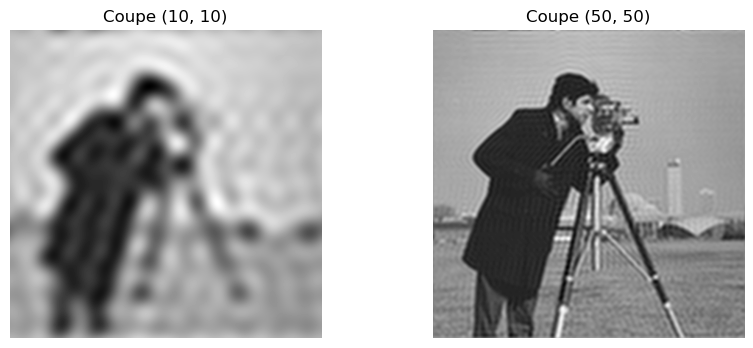

In [9]:
def ideal_lowpass_filter(image, cutoff):
    if len(cutoff) != 2:
        raise ValueError('cutoff doit contenir deux entiers (fy, fx)')

    fy, fx = map(int, cutoff)
    freq = np.fft.fftshift(np.fft.fft2(image))
    mask = np.zeros_like(freq, dtype=float)

    my, mx = freq.shape
    cy, cx = my // 2, mx // 2

    y_min = max(0, cy - fy)
    y_max = min(my, cy + fy + 1)
    x_min = max(0, cx - fx)
    x_max = min(mx, cx + fx + 1)
    mask[y_min:y_max, x_min:x_max] = 1.0

    filtered_freq = freq * mask
    filtered = np.fft.ifft2(np.fft.ifftshift(filtered_freq))
    return filtered.real

cutoffs = [(10, 10), (50, 50)]
filtered_images = [ideal_lowpass_filter(X, c) for c in cutoffs]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, img, c in zip(axes, filtered_images, cutoffs):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Coupe ({c[0]}, {c[1]})')
    ax.axis('off')
plt.show()


4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform.

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $N>N_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) (or `np.reshape` or built-in `np.outer`).

**Answer:**

La convolution gaussienne étale les intensités et floute l'image : les contours deviennent moins nets, les variations rapides disparaissent et l'image résultante est légèrement plus grande du fait du zéro-padding utilisé pour la convolution linéaire.

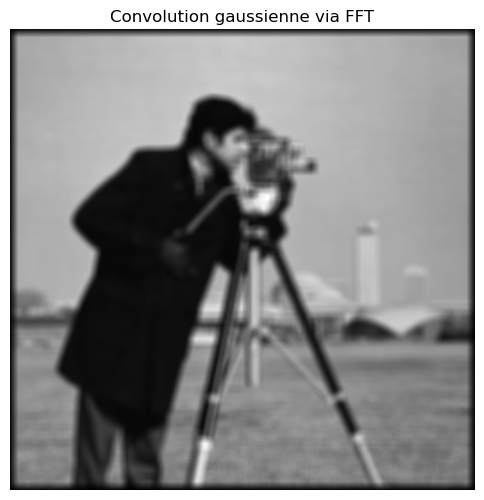

In [10]:
def gaussian_window(length, sigma):
    """Retourne une fenêtre gaussienne normalisée de taille `length`.
    """
    center = (length - 1) / 2.0
    positions = np.arange(length) - center
    window = np.exp(-(positions ** 2) / (2 * sigma ** 2))
    return window

M2 = N2 = 10
sigma_y = sigma_x = 10.0
wy = gaussian_window(M2, sigma_y)
wx = gaussian_window(N2, sigma_x)
H = np.outer(wy, wx)
H /= H.sum()


def linear_convolution_fft(image, kernel):
    m1, n1 = image.shape
    m2, n2 = kernel.shape
    m = m1 + m2 - 1
    n = n1 + n2 - 1

    padded_image = np.zeros((m, n), dtype=float)
    padded_kernel = np.zeros((m, n), dtype=float)
    padded_image[:m1, :n1] = image
    padded_kernel[:m2, :n2] = kernel

    conv_freq = np.fft.fft2(padded_image) * np.fft.fft2(padded_kernel)
    return np.fft.ifft2(conv_freq).real

convolved = linear_convolution_fft(X, H)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(convolved, cmap='gray')
ax.set_title('Convolution gaussienne via FFT')
ax.axis('off')
plt.show()